In [2]:
import torch
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt


def normalize_weights(weights: np.ndarray, normalization_type: str) -> np.ndarray:
    if normalization_type == "token-wise":
        if len(weights.shape) != 2 or weights.shape[1] < 2:
            print("Cannot apply token-wise normalization to one sentence, setting global normalization")
            normalization_type = "global"
        else:
            for tok_idx in range(weights.shape[1]):
                max_, min_ = weights[:, tok_idx].max(), weights[:, tok_idx].min()
                weights[:, tok_idx] = (weights[:, tok_idx] - min_) / (max_ - min_)
            normalized_weights = weights
    if normalization_type == "sentence-wise":
        if len(weights[0]) == 1: 
            print("Cannot apply sentence-wise normalization to one word, setting global normalization")
            normalization_type = "global"
        else:
            normalized_weights = []
            for layer_idx in range(len(weights)):
                max_, min_ = weights[layer_idx].max(), weights[layer_idx].min()
                normalized_weights.append((weights[layer_idx] - min_) / (max_ - min_))
            normalized_weights = np.array(normalized_weights) 
    if normalization_type == "global":
        max_, min_ = weights.max(), weights.min()
        normalized_weights = (weights - min_) / (max_ - min_)
    return normalized_weights

def replace_bad_chars(input_string):
    encoded_string = input_string.encode('windows-1251', errors="replace")
    decoded_string = encoded_string.decode('windows-1251')
    return decoded_string

def logit_lens(model, tokenizer, text):
    device = model.device
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    labels = input_ids.clone()
    labels[:, 0] = -100
    target_ids = labels[:, 1:].contiguous()

    with torch.no_grad():
        outputs = model(input_ids, labels=labels, output_hidden_states=True)
        hiddens = outputs.hidden_states

        losses = []
        predictions = []
        decoded_words = []
        for layer_idx in range(len(hiddens)):
            y = hiddens[layer_idx]

            # assert model.config.pretraining_tp == 1 # см код modeling_llama.py, если это не выполнено, там более хитро считаются логиты
            logits = model.lm_head(y).float()
            ids = logits[:, :-1, :].argmax(dim=-1)
            predictions.append(ids[0])
            softmax_logits = torch.softmax(logits, dim=-1)[:, :-1, :]
            # print(softmax_logits.shape)
            per_token_loss = -torch.log(softmax_logits[range(softmax_logits.shape[0]), range(softmax_logits.shape[1]), ids])
            losses.append(per_token_loss[0])
            decoded_words.append([replace_bad_chars(tokenizer.decode([tok])) for tok in ids[0]])

    # num_tokens = len(decoded_words[0])
    # for j in range(num_tokens):
    #     max_len = max([len(decoded_words[i][j]) for i in range(len(decoded_words))])
    #     for i in range(len(decoded_words)):
    #         l = len(decoded_words[i][j])
    #         if l > 0:
    #             decoded_words[i][j] += (max_len - l) * ' '
    losses = torch.stack(losses).cpu().detach().numpy()
    predictions = torch.stack(predictions)

    return predictions, losses, decoded_words


def get_text_size(text, font_size=12):
    fig, ax = plt.subplots()
    text_artist = ax.text(0, 0, text, fontsize=font_size)
    bbox = text_artist.get_window_extent(renderer=fig.canvas.get_renderer())
    plt.close(fig)
    return bbox.width, bbox.height

def plot_word_table(words, weights, top_labels):
    nrows, ncols = len(words), len(words[0])

    # Определим ширину каждой колонки и высоту строк, увеличенные в 1.5 раза
    col_widths = [1.5 * max(get_text_size(words[row][col])[0] for row in range(nrows)) for col in range(ncols)]
    row_heights = [1.5 * max(get_text_size(words[row][col])[1] for col in range(ncols)) for row in range(nrows)]
    label_heights = [1.5 * get_text_size(label)[1] for label in top_labels]

    # Коэффициенты для перевода из пикселей в фигуру
    fig_width = sum(col_widths) / plt.gcf().dpi
    fig_height = (sum(row_heights) + label_heights[0]) / plt.gcf().dpi

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Получаем цветовую карту
    ver = mpl.__version__
    if ver < '3.9.0':
        cmap = mpl.cm.get_cmap('RdYlGn')
    else:
        cmap = plt.get_cmap('RdYlGn')

    # Отрисовка слов в ячейках с соответствующими размерами
    for i in range(nrows):
        for j in range(ncols):
            weight = weights[i][j]
            color = cmap(weight)
            color_with_alpha = (color[0], color[1], color[2], 0.5)  # Устанавливаем прозрачность в 0.5
            rect = plt.Rectangle((sum(col_widths[:j]) / plt.gcf().dpi, sum(row_heights[:i]) / plt.gcf().dpi + label_heights[0] / plt.gcf().dpi),
                                 col_widths[j] / plt.gcf().dpi, row_heights[i] / plt.gcf().dpi, facecolor=color_with_alpha)
            ax.add_patch(rect)
            plt.text(sum(col_widths[:j]) / plt.gcf().dpi + col_widths[j] / (2 * plt.gcf().dpi),
                     sum(row_heights[:i]) / plt.gcf().dpi + row_heights[i] / (2 * plt.gcf().dpi) + label_heights[0] / plt.gcf().dpi,
                     words[i][j], ha='center', va='center', fontsize=12, color='black')

    # Отрисовка меток на белом фоне
    for j in range(ncols):
        rect = plt.Rectangle((sum(col_widths[:j]) / plt.gcf().dpi, 0),
                             col_widths[j] / plt.gcf().dpi, label_heights[0] / plt.gcf().dpi, facecolor='white')
        ax.add_patch(rect)
        plt.text(sum(col_widths[:j]) / plt.gcf().dpi + col_widths[j] / (2 * plt.gcf().dpi),
                 label_heights[0] / (2 * plt.gcf().dpi),
                 top_labels[j], ha='center', va='center', fontsize=12, color='black')

    plt.xlim(0, fig_width)
    plt.ylim(0, fig_height)
    plt.gca().invert_yaxis()
    ax.set_aspect('auto')
    # plt.axis('off')
    fig.show()

In [7]:
import torch
from llm_microscope import  (
  calculate_anisotropy_torch,
  intrinsic_dimension,
  procrustes_similarity,
  procrustes_similarity_centered,
  load_enwiki_text
)
import llm_microscope
device = 'cpu'

X = torch.randn((1000, 10)) # pseudo-random "features", 1000 vectors with dim=10.
Y = torch.randn((1000, 10)) # pseudo-random "features", 1000 vectors with dim=10.

anisotropy = calculate_anisotropy_torch(X) # anisotropy score
int_dim = intrinsic_dimension(X, device) # intrinsic dimension
linearity_score = procrustes_similarity(X, Y) # linearity score from the paper
centered_linearity_score = procrustes_similarity_centered(X, Y) # the same as linearity between X and Y - X


# You can also download the dataset that we used in the paper using load_enwiki_text function:
text = llm_microscope.load_enwiki_text()

The dataset size is about 75 MB, downloading from Github may take some time...
You can also download it manually from  https://github.com/AIRI-Institute/LLM-Microscope/raw/main/enwik88.txt


In [8]:
import torch
from transformers import AutoTokenizer, GPT2LMHeadModel
from llm_microscope import logit_lens, normalize_weights, plot_word_table, replace_bad_chars

device = 'cuda'
model_name = "ai-forever/rugpt3small_based_on_gpt2"
# text = "Меня зовут Мирон мне 24 года, значит я родился в 2000 году."
model_checkpoint = "ai-forever/rugpt3small_based_on_gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.padding_side = "right"
model = torch.load("model_base_final.pth").to(device)
# tokenizer= AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).bfloat16().to(device)

tokens = tokenizer.encode(text)
words = [tokenizer.decode([tok]) for tok in tokens]
words = [replace_bad_chars(word) for word in words]

predictions, losses, decoded_words = logit_lens(model, tokenizer, text)
losses = normalize_weights(-losses, normalization_type="global") 

plot_word_table(decoded_words, losses, words)

TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

<Figure size 640x480 with 0 Axes>

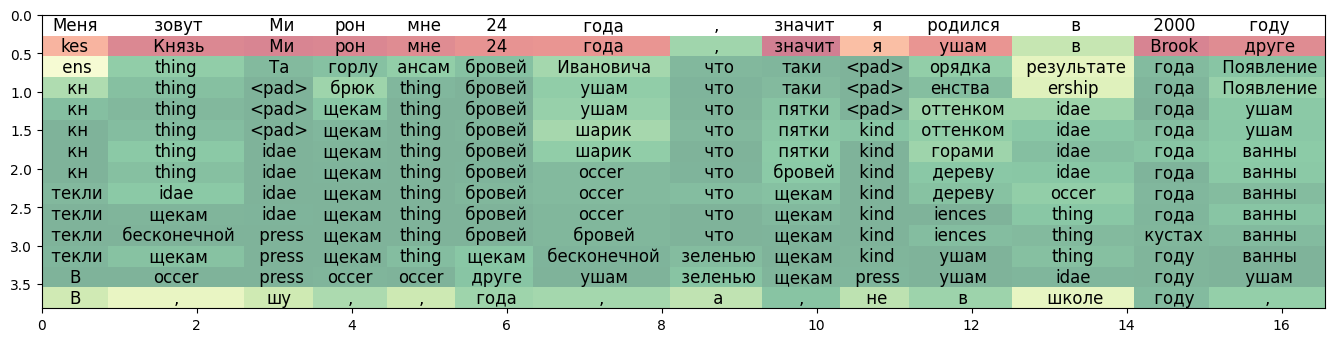

In [6]:
model_checkpoint = "ai-forever/rugpt3small_based_on_gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.padding_side = "right"
model = torch.load("model_birm_max_final.pth").to(device)
# tokenizer= AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).bfloat16().to(device)

tokens = tokenizer.encode(text)
words = [tokenizer.decode([tok]) for tok in tokens]
words = [replace_bad_chars(word) for word in words]

predictions, losses, decoded_words = logit_lens(model, tokenizer, text)
losses = normalize_weights(-losses, normalization_type="global") 

plot_word_table(decoded_words, losses, words)

In [1]:
model_checkpoint = "ai-forever/rugpt3small_based_on_gpt2"

In [2]:
import math
import numpy as np
import torch
import random
from tqdm import tqdm
from transformers import AutoTokenizer, GPT2LMHeadModel
import json

import matplotlib.pyplot as plt

C:\ProgramData\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda:0')

In [4]:
def calculate_anisotropy_torch(emb):
    """
    Calculate the anisotropy of a set of embeddings.

    Parameters:
    emb: torch tensor of shape (n_samples, n_features) representing the embeddings.

    Returns:
    float: The anisotropy value.
    """

    # embeddings = torch.FloatTensor(embeddings).to(DEVICE)
    embeddings = emb - emb.mean(dim=0, keepdim=True)
    U, S, Vh = torch.linalg.svd(embeddings, full_matrices=False)
    cov_einvalues = (S*S) / (embeddings.shape[0] - 1)
    
    anisotropy = float(cov_einvalues.max() / cov_einvalues.sum())
    return anisotropy

def intrinsic_dimension(emb, debug=False, reduction_factor=5):
    """
    emb: n x dim torch tensor
    """
    with torch.no_grad():
        eps = 1e-8
        embeddings = emb.to(torch.float64)
        embeddings = embeddings - embeddings.mean(dim=0, keepdim=True)
        avg_len = (embeddings*embeddings).sum(dim=1).sqrt().mean()
        embeddings = embeddings / avg_len

        r1 = []
        r2 = []
        n = len(embeddings)
        for i in range(n):
            dsts = torch.nn.functional.pairwise_distance(
                embeddings[i, None, :],
                embeddings[None, :, :],
                eps=0
            )[0]
            dsts = torch.cat([dsts[:i], dsts[i+1:]])
            r1.append(torch.kthvalue(dsts, k=1)[0])
            r2.append(torch.kthvalue(dsts, k=2)[0])
        r1 = torch.tensor(r1).to(device)
        r2 = torch.tensor(r2).to(device)
        bad_cases = (r1 < eps)
        r1[bad_cases] = eps
        r2[bad_cases] = eps
        mu = r2 / r1
        mu[bad_cases] = -1
    
        mu, ind = torch.sort(mu)
        all_mu = mu.clone().cpu().detach()
        useless_items = int((mu <= 1+eps).sum()) 
        mu = mu[useless_items:]
        n = mu.shape[0]
        if debug:
            print('Removed points: ', useless_items)
            plt.plot(mu.cpu().detach().numpy())
            plt.show()

        f_emp = torch.arange(1+useless_items, n + 1 + useless_items, device=device) / (n + useless_items)
        num_dots_to_use = min(n  // reduction_factor, n - 1)
        
        mu_log = torch.log(mu)[:num_dots_to_use]
        dist_log = -torch.log(1 - f_emp)[:num_dots_to_use]

        if debug:
            print('Regression points:', len(mu_log))
            plt.scatter(mu_log.cpu().detach().numpy(), dist_log.cpu().detach().numpy(), marker='.')
            plt.show()

        dim = float((mu_log*dist_log).sum() / (mu_log*mu_log).sum())

        if debug:
            print('Dim: ', dim)
    return float(dim) #, all_mu

def get_est_svd(X, Y):
    """
    X -- torch tensor with shape [n_samples, dim]
    Y -- torch tensor with shape [n_samples, dim]

    Approximates Y matrix with linear transformation Y = XA
    """
    U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    A_estimation = Vh.T * (1 / S)[None, ...] @ U.T @ Y # Y=XA
    Y_est =  X @ A_estimation
    return Y_est

def procrustes_similarity(x, y):
    """
    x -- torch tensor with shape [n_samples, dim]
    y -- torch tensor with shape [n_samples, dim]
    """
    with torch.no_grad():
        
        X = x - x.mean(dim=0, keepdim=True)
        Y = y - y.mean(dim=0, keepdim=True)
    
        X = X / X.norm()
        Y = Y / Y.norm()
    
        Y_estimation = get_est_svd(X, Y)
    
        y_error = (Y_estimation - Y).square().sum()
        sim = float(1 - y_error)
    return sim

def procrustes_similarity_centered(x, y0):
    """
    x -- torch tensor with shape [n_samples, dim]
    y -- torch tensor with shape [n_samples, dim]
    """
    with torch.no_grad():
        y = y0 - x
        
        X = x - x.mean(dim=0, keepdim=True)
        Y = y - y.mean(dim=0, keepdim=True)
    
        X = X / X.norm()
        Y = Y / Y.norm()
    
        Y_estimation = get_est_svd(X, Y)
    
        y_error = (Y_estimation - Y).square().sum()
        sim = float(1 - y_error)
    return sim

In [7]:
text = """
	УДК 004.8
Название статьи
 Цгоев Ч.А.1, Братенков М.А.1, Сахаров Д.И.1, Травников В.А.1, Серёдкин А.В.1,2, Калинин В.А.1, Мулляджанов Р.И.1,2
1Новосибирский государственный университет, 
Новосибирск, Россия

2Институт теплофизики СО РАН, Новосибирск, Россия

 c.tsgoev@g.nsu.ru, m.bratenkov@g.nsu.ru, d.sakharov@g.nsu.ru, v.travnikov@g.nsu.ru, a.seredkin@g.nsu.ru, v.kalinin@g.nsu.ru, r.mullyadzhanov@g.nsu.ru. 

Аннотация

Физически-информированные нейронные сети (PINN) представляют собой инновационный метод решения разнообразных задач в областях математики, физики и инженерии. PINN объединяет в себе концепции нейронных сетей и физических уравнений с целью моделирования и анализа различных физических процессов. В частности, PINN может применяться для решения дифференциальных уравнений, включая одномерное уравнение конвекции. Исследование показало, что стандартная реализация PINN эффективно решает одномерное уравнение конвекции при относительно небольших значениях скорости конвекции, однако расходится при повышенных значениях этого параметра. В настоящей работе представлен обзор существующих подходов к решению одномерного уравнения конвекции с использованием PINN, а также демонстрируется, как различные методы могут улучшить качество моделей. Результаты сравнения методов свидетельствуют о превосходстве подхода, основанного на динамическом изменении сетки в зависимости от невязки на текущем шаге обучения, по сравнению с другими подходами.



ВВЕДЕНИЕ
	Активное развитие методов глубокого обучения приводит к созданию новых инструментов в науке и инженерии, которые могут упростить математическое моделирование сложных физических систем. Нейронные сети рассматриваются как вспомогательный, а иногда и альтернативный подход к решению уравнений в частных производных. Первоначальные попытки применения нейросетевых методов основывались на классическом обучении с учителем, где обучающие данные создавались с помощью численного решателя, а нейросеть обучалась на парах «пример-ответ». Такие методы в контексте решения дифференциальных уравнений часто требуют значительных усилий из-за необходимости генерации разнообразной и качественной обучающей выборки. Кроме того, эти подходы страдают от недостатка точности и обобщающей способности. Для получения качественного описания моделируемого процесса необходимо не только создать подходящую обучающую выборку, но и внедрить физическое знание в процесс обучения нейросети.
Одной из концепций, позволяющих интегрировать физическое знание в архитектуру нейронной сети, являются физически-информированные нейронные сети  (PINN) [1]. Этот метод включает законы физики (уравнения в частных производных, граничные условия, начальные условия и т.д.) непосредственно в процесс обучения через функцию потерь модели. Такой подход использует не только синтетические или экспериментальные данные, но и физические законы, управляющие системой, что позволяет достичь более точного и надежного приближения.
Использование PINN, помимо практических результатов [1], показывающих состоятельность подхода, имеет также (в случае некоторых классов задач) и теоретическое  обоснование, гарантирующее сходимость нейронной сети к искомому решению уравнений в частных производных, при увеличении числа нейронов [2]. Одно из ключевых преимуществ PINN заключается в возможности решения уравнения без построения «классической» регулярной/нерегулярной расчетной сетки, даже при решении задач с довольно сложной геометрией. Это достигается благодаря использованию алгоритма автоматического дифференцирования для подсчета входящих в дифференциальное уравнение производных и, следовательно, расчета итоговой невязки, а также всех компонент для градиентного спуска. Изначально PINN был разработан для работы с классическими уравнениями в частных производных, однако его легко адаптировать для решения интегродифференциальных уравнений, дробных дифференциальных уравнений [3] и стохастических дифференциальных уравнений [4]. 
Несмотря на свои преимущества, физически-информированные нейронные сети сталкиваются с рядом проблем, особенно касающихся их обучения и применения к определенным видам задач. Одна из основных трудностей заключается в отсутствии четких рекомендаций по оптимизации архитектуры, параметров обучения сети, а также методов обучения. Это делает процесс настройки PINN сложным и не интуитивным. Нет универсального подхода к улучшению точности аппроксимации решений, аналогичного уточнению сетки в классических численных методах или изменению сложности модели в традиционных нейросетевых подходах. 
Кроме того, физически-информированные нейросети (PINN) могут демонстрировать плохую обучаемость и сходимость при решении жестких или плохо обусловленных задач [5]. Эти проблемы усложняют применение метода и требуют дополнительных исследований для разработки более эффективных подходов к обучению и адаптации моделей PINN к различным типам задач. В частности, возникают следующие проблемы: проблема тривиального или нулевого решения, которая заключается в том, что физически-информированная нейросеть может сходиться к некорректному нулевому решению или плавно в него переходить в некоторой области. Это происходит, когда сеть не может адекватно моделировать сложное поведение системы, переносить информацию от границ во внутреннюю часть области и выбирает простейший вариант, равный нулю, либо плавно затухает к нему [6]. Дополнительно, представляет трудность корректного выбора обучающего множества для сложных задач [7]. Несмотря на относительную простоту генерации дискретной сетки, определение оптимального размера выборки представляет собой сложную подзадачу, для которой пока что нет каких-то определенных алгоритмов. Стоит также упомянуть, что невозможно заранее гарантировать точность итоговой аппроксимации и стабильность обучения при фиксированной выбранной архитектуре [5]. Такие особенности показывают, что обучение и настройка PINN требуют дополнительных, в том числе численных исследований и разработки методик для повышения их универсальности и эффективности в широком спектре приложений. 
В данной статье рассматривается применение PINN для решения задачи конвекции – одной из самых проблемных модельных задач в рамках физически-информированного подхода. Ранее было показано [6], что при увеличении жесткости посредством варьирования параметра скорости конвекции β, обучение PINN значительно страдало, приводя к уже упомянутому эффекту затухания к нулю. Предложенные на сегодняшний день решения данной проблемы не всегда оказываются эффективными и требуют достаточно сложной настройки. Действительно, они сильно зависят от заданной геометрии задачи, могут быть трудозатратным и увеличивать итоговое время обучение PINN в несколько раз. 
С другой стороны, существуют достаточно эффективные инструменты обучения, которые ранее не рассматривались в рамках данной проблемы. В частности, для решения проблемы распространения начальных данных следует исследовать лагранжеву регуляризацию, немного модифицированную относительно предложенных методов в статьях [8, 9]. Эта методика, путем задания баланса внутри области и на границе, может существенно изменить «важность» корректного нетривиального решения и привести к лучшей сходимости. Далее, рассматриваются адаптивные сетки: выбор распределения обучающего множества может значительно влиять на решение, поэтому рассматривается подход, в котором расчетная сетка динамически изменяется по ходу обучения в зависимости от локализации областей с большой невязкой [10]. Гипотетически, такой подход может выделить зоны, где происходит затухание, и наблюдается наибольшая невязка, что может привести к существенно лучшей сходимости. Наконец, рассматривается поэтапное обучение модели PINN на задачах конвекции с постепенным увеличением скорости конвекции. 
ОСНОВЫ PHYSICS-INFORMED NEURAL NETWORKS
 Семейство PINN образует класс нейронных сетей, интегрирующих физические законы в свою структуру и в основном направленных на решение дифференциальных уравнений и их систем. Основная цель PINN заключается в улучшении предсказательной мощности и точности нейросетевых моделей в научных и инженерных задачах за счет внедрения знаний о физических процессах в цикл обучения. Включение физических законов происходит через добавление специальных членов в функцию потерь, которые обеспечивают соответствие решения физическим уравнениям или заданным экспериментальным наблюдениям. Этот подход позволяет нейронной сети не просто аппроксимировать данные, но и соблюдать фундаментальные законы природы, что особенно ценно в задачах, где важна физическая точность модели.
В PINN нейронная сеть функционирует как аппроксиматор решений NN(t,x,) = L(WLL-1(WL-11(W1[x, t ]T+b1)  + bL-1)+ bL)состоящая из обучаемых параметров: весов W и смещений b, обозначаемых совокупно через , а также из функций активации  где входные данные, как правило, представляют собой пространственные и/или временные координаты. На сегодняшний день нет каких-либо ограничений на архитектурную часть PINN, и здесь могут быть использованы вполне стандартные модели, такие как полносвязные сети. Основная отличительная особенность физически-информированных нейронных сетей, как уже говорилось, заключается в использовании специфических функций потерь, которые включают термины, отражающие уровень нарушения установленных физических законов. Чаще всего функция потерь для PINN представляет собой сумму невязок дифференциального уравнения, а также ошибок в начальных и граничных условиях: 
L() = LE() +i αi LBi () + j βj LICj () +γLad()  
Где L() – общая функция потерь, по которой происходит шаг оптимизации весов нейронной сети; LE() – функция потерь, связанная с невязкой дифференциального уравнения или системы; LB() – функция потерь, связанная с граничными условиями; LIC() – функция потерь, связанная с  начальными/входными условиями, Lad()  – дополнительная функция потерь, которая может учитывать отклонения от имеющихся экспериментальных данных или других априорных условий. При этом α, β и γ представляют собой веса, позволяющие регулировать вклад соответствующих компонентов функции потерь, а через  обозначены обучаемые веса нейронной сети. 
Особенность данной функции потерь заключается в необходимости вычисления производных различных порядков аппроксимируемой функции по входным параметрам в процессе обучения. В методе PINN критически важно обеспечить непрерывную дифференцируемость всех слоев нейронной сети, что делает возможным эффективное применение автоматического дифференцирования [1]. Автоматическое дифференцирование позволяет с высокой точностью вычислять производные целевых функций (выходов нейронной сети) в заданной расчетной сетке, что является фундаментальным элементом метода PINN. Это, с одной стороны, позволяет отказаться от традиционных методов построения расчётных сеток. С другой стороны, благодаря обобщающей способности нейронных сетей, обученную модель можно использовать на любой дискретной сетке, что приводит к возможности разработки гибридного подхода, объединяющего PINN с классическими численными методами.
По сути PINN решает оптимизационную задачу минимизации L(),  зависящей от весов нейронной сети. Общая схема процесса оптимизации представлена на рисунке … . На вход сети подаются точки коллокации, на основе которых модель генерирует прогнозы значений целевых функций. С использованием техники автоматического дифференцирования вычисляются необходимые частные производные. Эти производные затем используются для вычисления невязок, а также ошибок в начальных, входных и граничных условиях, которые затем интегрируются в функцию потерь. Методом обратного распространения ошибки [11] вычисляются градиенты весов сети, и на последнем шаге цикла осуществляется шаг оптимизации, обновляющий веса модели. Процесс продолжается пока не пройдет заранее заданное количество шагов.
Как уже говорилось, одним из ключевых преимуществ данного подхода является отсутствие необходимости в использовании традиционных методов построения расчетных сеток для аппроксимации решений. Это существенно упрощает процесс численного решения дифференциальных уравнений. Дополнительно же, стоит отметить: PINN обладает уникальной способностью принимать в качестве входных данных не только временные и пространственные координаты, но и различные параметры задачи, такие как коэффициенты дифференциальных уравнений, включая теплопроводность, число Рейнольдса и другие. Это позволяет PINN моделировать и решать целый класс задач с различными параметрами, не требуя пропорционального увеличения объема обучения нейронной сети. Благодаря этому, нейросеть обучается на обобщенной функции, которая способна учитывать изменения параметров задачи. В результате, одна и та же обученная модель может эффективно применяться для широкого диапазона значений параметров, обеспечивая решение различных задач в рамках одной архитектуры. Это значительно повышает гибкость и эффективность метода, поскольку исключает необходимость повторного обучения сети при изменении параметров задачи и позволяет решать множество связанных задач одновременно, что существенно снижает вычислительные затраты и время обучения.

КОНФИГУРАЦИЯ
Задача конвекции. Рассматривается одномерная нестационарная тестовая задача конвекции, представляющая трудности в обучении для физически-информированных нейронных сетей [5]. Математическая постановка выглядит следующим образом:
ut +ux=0    при t [0,tmax], x [0,2], 
u(t,0) = u(t, 2)    при t [0,tmax],
u(0,x) = sin(x)    при x [0,2],
где u – искомая функция; ut  и ux– частные производные u по t и x соответственно;  – параметр задачи, определяющий скорость конвекции в пространстве,  tmax – определяет временной интервал, в пределах которого ищется решение задачи. В рамках данной постановки классическая физически-информированная нейронная сеть испытывает трудности, связанные с доминированием нулевого решения по мере увеличения параметра   (см. рис. 1). Решение задачи представляется следующим образом:
u = sin(t-x)

Лагранжева регуляризация. 
Лагранжева регуляризации основана на методе множителей Лагранжа. Идея подхода состоит в модификации функции потерь, путем добавления обучаемых весовых коэффициентов для каждой точки и последующего их изменения путем решения задачи двойной оптимизации: 
min maxF,B, C L(; F, B, C)=LD() + LF(; F)+ LB(; B)+ LC(; C)
LF(, F) =i=1N1F(i)(F(x(i);)) 
LB(, B) =i=1N2B(i)(B(x(i);)) 
LC(, C) =i=1N3C(i)(C(x(i);)) 
Где LD – это функции потерь «основного» дифференциального уравнения; LF, LB, LC – функции потерь начальных, граничных и иных дополнительных условий/уравнений; i – множители Лагранжа; i  – область, где выполняется соответствующее условие;  – функция с неотрицательной областью значений; F,B,C- условия.
На первом шаге к ошибкам в каждой точке области для начальных и граничных условий применяется максимизация методом градиентного подъема по множителям Лагранжа. На этом шаге ошибка в каждой точке коллокации умножается на  дополнительный весовой коэффициент. Таким образом, для точек с большой ошибкой будет назначен более высокий весовой коэффициент, что позволит модели на следующем шаге уделять больше внимания именно этим точкам. Это предотвращает ситуацию, когда несколько точек с высокими ошибками могут быть почти игнорированы на фоне средней ошибки по всему набору данных. На втором шаге модель минимизирует сумму всех невязок. Такой подход помогает сгладить поверхность ошибок, убирая тем самым множество локальных минимумов. В качестве функции  в эксперименте ниже использовалась квадратичная функция.

Адаптивные расчетные сетки. В данной работе представлена адаптивная стратегия обновления расчетной сетки, которая основывается на анализе распределения поля невязок на каждой итерации вычислительного процесса [10]. Основной целью является улучшение точности модели за счет оптимального выбора точек для обучения, основываясь на распределении ошибок предсказания. 
На определенной итерации вычисляется аппроксимация поля невязок(x) = |L(x;u(x))|, которая демонстрирует области с наибольшими ошибками предсказания нейросети. Используя это поле, создается вероятностное распределение, которое служит основой для выбора обучающих точек: 
 p k(x)E[k(x)] + c 
Параметр k управляет концентрацией точек: при больших значениях k точки сосредотачиваются в областях с высокой невязкой, при меньших значениях — распределяются более равномерно по всей области. В то время как параметр c служит для смещения и масштабирования вероятностного распределения.
	Эта адаптивная стратегия предполагает постепенное добавление точек в обучающую выборку на основе вероятностного распределения. При этом, точки с наименьшими значениями невязок исключаются, что позволяет поддерживать постоянный размер обучающей выборки, изменяя только её распределение в области. Важным аспектом предложенного метода является динамическое перераспределение обучающей выборки, что предположительно обеспечивает постоянное улучшение качества предсказаний нейросети. Такой подход позволяет модели сосредотачиваться на наиболее сложных для предсказания областях, что потенциально может привести к улучшению её обобщающей способности.

Постепенный переход к жесткой постановке. Как будет показано ниже, метод физически-информированных нейронных сетей демонстрирует высокую эффективность при решении задачи конвекции при малых значениях параметра конвекции (Рис ?). В данном случае модель не сталкивается с проблемой нулевого решения. Однако, по мере увеличения значения параметра конвекции , указанная проблема начинает проявляться все более явно. Одним из подходов для её преодоления является постепенное увеличение значения этого параметра. В данной работе рассматриваются два подхода к решению этой проблемы.
В первом подходе используется одна нейросетевая модель, которая аппроксимирует целевую функцию. Процесс обучения разбивается на несколько этапов. На каждом этапе модель обучается до достижения установившегося состояния с фиксированным значением параметра конвекции . После этого, на следующем этапе, значение параметра увеличивается, а обучение продолжается, начиная с уже обученной на предыдущем этапе модели. Таким образом, каждый этап (за исключением первого) представляет собой переобучение модели с предыдущего этапа для нового значения параметра. Второй подход предполагает непрерывное, равномерное увеличение значения параметра конвекции в процессе обучения, без разделения на этапы. Такой метод позволяет плавно адаптировать модель к изменениям параметра, что может способствовать более стабильному и эффективному обучению.

ЭКСПЕРИМЕНТАЛЬНАЯ ЧАСТЬ И  АНАЛИЗ РЕЗУЛЬТАТОВ
Конфигурации экспериментов. В проведенных далее экспериментах в качестве модели использовалась полносвязная нейронная сеть, состоящая из четырех слоев, каждый из которых содержит по 128 нейронов.  Размерность входного слоя составляла 2, а выходного — 1. Количество эпох варьировалось от 100 000 до 300 000. Количество эпох выбиралось из соображений сходимости. Внутри области использовалось от 25 000 до 200 000 точек коллокации, а на каждой границе — от 2 000 до 16 000 точек коллокации, при соотношении 25:2. Все точки генерировались согласно равномерному распределению. Для оптимизации использовался экспоненциальный алгоритм уменьшения шага обучения [12], с уменьшением шага на 0.99997 на каждой эпохе. В качестве входных данных использовались точки коллокации в пространственно-временном пространстве (x,t), а выходные данные модели представляли собой предсказанные значения целевой функции u в этих точках (x,t).

Проблема тривиального решения. Продемонстрируем, что при относительно «большом» значении параметра  классический PINN без должной настройки не справляется с аппроксимацией искомого решения. В частности, в рамках  эксперимента рассмотрим следующую конфигурацию: пусть  = 30; tmax = 10; обучение длится около 100 000 итераций; генерируется около 25 000 точек внутри области. 
	
Точное решение
Предсказание
Ошибка



Рис. 1.  Пространственные распределения точного решения, предсказаний нейросети и ошибки.

	Как и в [10] расчеты продемонстрировали (см. рис. 1), что классический PINN плохо справляется с данной задачей. Так, модель не смогла распространить начальные данные на всю область и подверглась проблеме тривиального решения. По распределениям ошибки (рис. 1, в) заметен резкий перепад значений по оси t. Это свидетельствует о том, что модель начала сходиться к локальному минимуму, прекратив распространение начальных данных. Данный эффект, в частности, объясняется тем, что нулевое решение удовлетворяет уравнению во внутренней области. Однако, в стандартной реализации обучения PINN и его архитектуре не предусмотрены механизмы для выхода из такого локального минимума, при котором граничные условия не соблюдаются, хотя значения во внутренней области аппроксимируются достаточно точно.
Нулевое решение начинает проявляться только при достижении определенного критического значения параметра конвекции. В ходе численного эксперимента параметры варьировались в диапазоне значений {1, 5, 10, 15, 20, 25, 30}. Как показано на Рис. 2, нейросеть успешно аппроксимирует решение задачи при значениях параметра <25. Однако с увеличением коэффициента уравнения наблюдается рост относительной ошибки по сравнению с аналитическим решением. В частности, в данной серии расчетов, при превышении порога ошибки в 10-1 можно заключить, что возникла проблема тривиального решения.


Рис. 2. Зависимость относительной ошибки с аналитическим решением от коэффициента .


На Рис. 3. представлены пространственные распределения предсказаний нейросети после 100 тыс. итераций обучения для задач с   [1,30]. Классический PINN может качественно описать решение вплоть до =25, где возникает проблема тривиального решения и относительная ошибка критически возрастает. Проблема нулевого решения в рассматриваемых моделях может проявляться в разных формах. В некоторых случаях, таких как при параметре  =25, данная проблема проявляется относительно резко, когда модель достаточно резко приходит к нулевому решению. В других случаях, например, при  =30, нулевое решение достигается более плавно, что свидетельствует о постепенной утрате модели способности обучаться на данном этапе. Однако, независимо от характера проявления этой проблемы, ни в одном из рассмотренных сценариев не удается дообучить модель таким образом, чтобы она могла эффективно распространять решение на всю область задачи. Это указывает на фундаментальные ограничения текущей методики, препятствующие полноценному распространению решения на заданной области.
=1
=10
=20
=25
=30





Рис. 3. Пространственные распределения предсказаний нейросети для задач с различным .


Точность модели на последовательности вложенных сеток. При решении дифференциальных уравнений с использованием классических численных методов обычно ожидается сходимость метода на последовательности вложенных сеток. Однако, как показано в данном исследовании, подобные эффекты сходимости не наблюдаются при использовании PINN. Для начала рассмотрим нежесткую задачу с =5, где нейросеть адекватно аппроксимирует искомую функцию. 
	В частности, на рисунке 4 представлены относительные ошибки предсказаний PINN, полученные на последовательности вложенных сеток. Результаты показывают, что использование статической сетки с ограниченным числом точек может привести к некачественным решениям. При этом, достигнув определенного размера обучающей выборки, дальнейшее ее увеличение не приводит к уменьшению ошибки. Таким образом, способы повышения точности и методы анализа сходимости, применяемые в классических численных методах, не подходят для PINN. Следовательно, для повышения точности предсказаний PINN требуется разработка новых подходов, в частности, модифицирующих процесс обучения рассматриваемого класса нейросетей.


Рис. 4. Зависимость относительной ошибки от числа точек N в статической сетке для задачи с =5. 

Кроме  того, продемонстрируем, что при решении жесткой задачи увеличение числа точек обучения также не позволяет преодолеть проблему тривиального решения. Так, на Рис. 5.1-5.2 представлены графики зависимости относительных ошибок предсказания на последовательности вложенных сеток и от эпохи обучения для моделей с фиксированной архитектурой при решении задачи с =30. Согласно Рис 5.1. начиная 64 тыс. точек постепенное увеличение их количества не приводит к существенному улучшению качества решения, при этом ошибка остается относительно большой. 


Рис. 5.1.  Зависимость относительной ошибки от числа точек N в статической сетке для задачи с 
=30. 
Рис. 5.2. Зависимость относительной ошибки от эпохи. Разными линиями обозначены модели, обученные на разном числе точек N.


На рисунке 6 представлены пространственные распределения предсказаний нейросети для различных значений N. Несмотря на возникновение проблемы тривиального решения, использование статической сетки с числом точек  64 тыс. позволяет модели продолжать решение от начального условия до t = 6 с затуханием. Это также подтверждается на рисунке 5.2, где видно, что ошибка для моделей, обученных на сетке с числом точек N  64 тыс., постепенно снижается в течение времени обучения, в то время как для меньших N ошибка остается неизменной.
Согласно рисунку 6, при обучении на малом числе точек модель не способна продолжить решение даже до t = 1. Таким образом, хотя увеличение числа точек и позволяет продлить решение, оно не способствует полному преодолению проблемы тривиального решения.

Точное решение
N = 32000
N = 64000
N = 256000




Рис. 6. Пространственные распределения предсказаний нейросети для различного числа генерируемых точек N в задаче с =30.


Анализ влияния лагранжевой регуляризации. В рамках PINN лагранжева регуляризация может считаться одной из наиболее перспективных стратегий адаптивной настройки весовых коэффициентов в функции потерь. Как уже было показано, этот подход позволяет динамически изменять вклад различных компонентов функции потерь в процессе обучения модели, обеспечивая баланс между сходимостью и точностью решения. Однако, несмотря на потенциал этой методики, её применение в определённых задачах может быть ограничено спецификой проблемы.
При исследовании влияния лагранжевой регуляризации для жесткой задачи с =30 конфигурация эксперимента включала следующие параметры: общее количество эпох составило 300 000. Сетка была статической, а количество точек коллокации внутри области составило 50 000, на границах — 4000 точек. Оптимальное число точек было выбрано на основе предыдущих расчетов с использованием последовательности сеток для обеспечения достаточной точности модели.
Согласно данным, представленным на рис. 8, использование лагранжевой регуляризации оказалось неэффективным для задачи конвекции. Даже наиболее успешная модель, работающая с минимальным шагом обучения, не продемонстрировала значительного улучшения качества решения по сравнению с базовой моделью. Видно, что модели по-разному приходят к проблеме тривиального решения, что указывает на трудности в достижении стабильной сходимости. Тем не менее ни одна из моделей не смогла успешно распространить начальные данные на всю область, что свидетельствует о недостаточной адаптивности данного подхода в контексте рассматриваемой задачи.


lr=0.001
lr=0.01
lr=0.1
lr=1




Рис. 8. Пространственные распределения предсказаний нейросети для задач с различным шагом максимизации.



	Таким образом, на основании проведенного анализа можно заключить, что лагранжева регуляризация не является подходящей стратегией для решения того набора проблем, который встречается в задаче конвекции. Эта методика, хоть и эффективна в других контекстах, сталкивается с серьезными ограничениями, что требует рассмотрения альтернативных методов оптимизации.

Анализ влияния адаптивной сетки. Адаптивные сетки используются в классических численных алгоритмах для повышения точности и эффективности решения задач с переменной степенью сложности, таких как задачи с разрывным решением или сложной геометрией областей. В контексте физически-информированных нейросетей адаптивные сетки могут применяться с той же целью, что и в классических численных методах: для дообучения нейросети на сложных участках с резкими градиентами или сложной геометрией. Это позволяет улучшить точность модели на этих критических зонах, однако, помимо этого, в данной работе предлагается использовать адаптивные сетки для самого процесса обучения. В этом случае сетка динамически изменяется в ходе обучения, что потенциально позволяет нейросети постепенно фокусироваться на наиболее проблемных участках, обеспечивая более эффективное перенесение граничных условий и улучшая общую обучаемость модели на всей области решения.
В проведенном эксперименте были заданы следующие условия: общее количество эпох составило 300 000; сетка пересчитывалась каждые 100 эпох; в пределах области обновлялось 1000 точек коллокации, в то время как на каждой границе обновлялось по 50 точек. Параметр k был установлен равным 1. Для четырех различных запусков эксперимента количество точек коллокации составляло 25 000, 50 000, 100 000 и 200 000 соответственно.


Рис 9. Зависимость относительной ошибки от эпохи. Разными линиями обозначены модели, обученные на разном числе точек N с адаптивной сеткой.


Как видно из Рис. 9, даже при использовании относительно небольшого количества точек коллокации модель с адаптивной сеткой демонстрирует способность намного эффективнее распространять решение в области. При этом дальнейшее увеличение числа точек коллокации, начиная с определенного уровня, не приводит к значительному улучшению качества решения и, как показано при обучении на 100 000 и 200 000 узлах, может даже немного ухудшить качество модели. При этом наилучшее решение продемонстрировало относительную ошибку равную 0.006. В частности, рассмотрим поведение невязок и сетки по ходу обучения для модели обучаемой на 100 000 точек.
N=10000
N = 25000
N = 50000
N = 100000
N = 300000















Рис 10. Пространственные распределения предсказаний нейросети по эпохам с отображением распределения невязок и распределения невязок вместе с сеткой.

Как показано на Рис. 10, наибольшая невязка наблюдается на границе между областью распространения решения и «тривиальным решением». Вследствие этого, предлагаемая адаптивная сетка на начальном этапе перебрасывает точки коллокации из области нулевого решения в область распространяемого решения, что позволяет модели избегать обучения в областях, куда решение еще не распространилось. По мере смещения границы между распространяемым решением и нулевой областью, сетка динамически адаптируется, следуя за этой границей. В конце обучения сетка распределяется более равномерно, концентрируясь в локальных областях с повышенной невязкой, что способствует улучшению качества решения в этих зонах.
Таким образом, проведенное исследование показало, что адаптивная сетка эффективно справляется с данной проблемой, обеспечивая высокое качество решения даже в условиях сложной динамики распространения. Этот результат демонстрирует новую, ранее не исследованную цель применения адаптивных точек коллокации — не только улучшение точности в областях с резкими градиентами, но и эффективное распространение решения (обучение нейросети) в регионы, где оно первоначально плохо распространяется. Теоретически данный подход может быть полезен и в других задачах, где наблюдаются аналогичные сложности с распространением решения.
 
Анализ влияния постепенного перехода к жесткой постановке. В задачах, связанных с моделированием конвекции посредством физически-информированных нейронных сетей, одной из ключевых стратегий оптимизации является метод поэтапного увеличения параметра скорости конвекции [5]. Эта стратегия была предложена, чтобы преодолеть проблему нулевого решения. Путем постепенного повышения интенсивности конвективных процессов в модели, данный подход способствует лучшей сходимости и повышению точности расчетов, так как модель начинает изучать уравнение с более простых для нее случаев. В рамках данной работы было решено проверить эффективность предложенного подхода, а также сравнить его с другими рассматриваемыми методами, оценивая как их результативность, так и простоту внедрения в различных численных моделях.
В рамках эксперимента было проведено 300 000 эпох с использованием статичной сетки. Для уменьшения шага обучения использовался экспоненциальный алгоритм, при котором шаг обучения снижался на 0,99997 на каждой эпохе. Исключение составили этапы после первого: на них в течение первых 2000 эпох шаг обучения увеличивался от 10^-6 до 0.001, что позволяло начинать обучение с очень малых шагов, постепенно увеличивая их до оптимального значения. Параметр  менялся различными способами. Для начала рассмотрим «наивное» резкое его увеличение по следующей схеме: 1,  5, 10, 15, 20, 25, 30.









=1
=10
=25
=30




Рис. 12. Пространственные распределения предсказаний нейросети для задач с различным 
.


Согласно рисункам 11-12, подход  «резкого» увеличения значения параметра не приводит к качественному улучшению предсказаний модели. Информация, накопленная на предыдущих этапах обучения, не используется новой моделью эффективно для достижения более точного решения. В результате модель продолжает сталкиваться с проблемой тривиального решения, что указывает на недостаточную эффективность данного подхода.
Исследуем более сложную стратегию изменения скорости конвекции, чтобы улучшить качество предсказаний модели и минимизировать влияние проблемы нулевого решения. В рамках этой стратегии параметр β равномерно увеличивается с 1 до 20 в течение первых 100000 эпох обучения.  После достижения значения β=20 скорость роста параметра замедляется, поскольку при значениях β больше 20 модель становится подверженной проблеме нулевого решения. Таким образом, в следующие 100000 эпох параметр β равномерно увеличивается до 30. На заключительном этапе, в оставшиеся 100000 эпох, модель дообучается с фиксированным значением β=30, что позволяет стабилизировать обучение и добиться более точных результатов. 


Рис. 13. Зависимость относительной ошибки с аналитическим решением от эпохи обучения. До 200 000 эпохи постепенно росло .





=1.19
=9.94
=25.02
=30




Рис. 14. Пространственные распределения предсказаний нейросети для задач с различным 
.


Согласно рисункам 13-14, второй подход успешно избежал появления нулевого решения. Модель смогла при больших значениях  обучиться до низких значений ошибки, которая составила примерно 0.004 в Евклидовой норме. Дальнейшие эксперименты показали, что чем более жесткой становится задача при увеличении , тем медленнее необходимо увеличивать данный параметр. Например, при проведении экспериментов с равномерным увеличением параметра  на всем фиксированном промежутке избавиться от эффекта нулевого решения не удалось. Этот результат подчеркивает важность контроля скорости изменения параметра  для успешного обучения модели и минимизации ошибок.
При этом «оптимальная» стратегия, вероятно, будет находиться где-то между резким увеличением параметра  и его постепенным изменением в ходе обучения. Поиск такой оптимальной стратегии представляет собой достаточно сложную, а, возможно, и нереализуемую задачу, учитывая множество факторов, влияющих на обучение модели. Кроме того, даже поиск не оптимальной, но просто эффективной стратегии с точки зрения борьбы с нулевым решением также оказывается сложной вычислительной задачей, особенно при рассмотрении достаточно больших значений параметра . При этом постепенное увеличение параметра β в ходе одного цикла обучения дало результат, сопоставимый с использованием адаптивных сеток. Учитывая простоту реализации и настройки адаптивных сеток в контексте физически - информированных нейросетей, этот последний подход представляется наиболее привлекательным. Он сочетает в себе эффективность и простоту, что делает его предпочтительным выбором для решения задач, связанных с избеганием подобного нулевого решения и улучшением качества предсказаний модели.

ВЫВОДЫ

В данной статье был проведен анализ применения физически-информированных нейронных сетей к решению задачи конвекции, которая представляет значительные трудности для методов глубокого обучения. Исследование подтвердило, что, хотя PINN обладает рядом преимуществ, таких как интеграция физических законов в сравнении с рядом других подходов глубокого обучения и отсутствие необходимости в классическом построении расчетных сеток, данный метод сталкивается с серьезными проблемами при решении жестких задач, таких как задачи конвекции с высокими значениями параметра скорости.
Ключевыми трудностями являются проблемы нулевого решения и низкой обучаемости модели при увеличении жесткости задачи. Рассмотренные в работе подходы, включающие исследование решения на последовательности вложенных сеток, лагранжеву регуляризацию, адаптивные сетки и поэтапное увеличение параметра конвекции, продемонстрировали различную степень эффективности в преодолении рассматриваемых проблем. В частности, адаптивные сетки и постепенное увеличение параметра конвекции показали наиболее стабильные результаты, обеспечивая лучшее распространение решения и снижение ошибок аппроксимации.
Особое внимание стоит уделить неожиданно эффективному применению адаптивных сеток. Эти сетки не просто позволили повысить точность в областях с резкими градиентами, а продемонстрировали способность значительно улучшать обучаемость модели в целом. Они позволили сосредоточиться на критических участках, предотвращая сходимость к тривиальному нулевому решению и улучшая распространение решения по области. Важно упомянуть, что в отличие от стратегии с поэтапным увеличением параметра конвекции, адаптивные сетки представляют собой относительно простой в настройке и использовании инструмент.
Несмотря на достигнутые результаты, дальнейшие исследования должны быть направлены на разработку более универсальных и надежных методов оптимизации обучения PINN. В частности, требуется более глубокое изучение механизмов адаптации сеток в различных типах задач и их влияние на общую сходимость модели. Также важным направлением будущих работ является исследование комбинированных методов, объединяющих адаптивные сетки с другими подходами, такими как поэтапное увеличение параметров задачи, для достижения максимальной эффективности.


Работа поддержана грантом Российского научного фонда N 19-79-30075-П. Вычислительные ресурсы предоставлены в рамках госзадания Института теплофизики СО РАН (FWNS-2022-0009).
Список литературы
M. Raissi, P. Perdikaris, G. Karniadakis, “Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations”. J. Comput. Phys.  volume 378, 1 February 2019, 686 - 707 pages.
J. Sirignano, K. Spiliopoulos, “DGM: A deep learning algorithm for solving partial differential equations”. J. Comput. Phys. volume 375, 15 December 2018, pages 1339–1364.
G. Pang, L. Lu, and G. E. Karniadakis, “fPINNs: Fractional physics-informed neural networks". SIAM Journal on Scientific Computing, volume 41, 2019, pp. A2603–A2626.
D. Zhang, L. Lu, L. Guo, and G. E. Karniadakis, “Quantifying total uncertainty in physics informed neural networks for solving forward and inverse stochastic problems”. Journal of Computational Physics, volume 397,  (2019), p. 108850.
Krishnapriyan, A., Gholami, A., Zhe, S., Kirby, R. and Mahoney, M.W., 2021. “Characterizing possible failure modes in physics-informed neural networks”. Advances in Neural Information Processing Systems, volume 34, pp.26548-26560.
Raphael Leiteritz, Dirk Pflüger, “How to Avoid Trivial Solutions in Physics-Informed Neural Networks”. arXiv.org 10 December 2021.
Pao-Hsiung Chiu, Jian Cheng Wong, Chinchun Ooi, My Ha Dao, Yew-Soon Ong, “CAN-PINN: A fast physics-informed neural network based on coupled-automatic–numerical differentiation method”. Computer Methods in Applied Mechanics and Engineering, volume 395, 15 May 2022, 114909
Shamsulhaq Basir, “Investigating and Mitigating Failure Modes in Physics-informed Neural Networks (PINNs)”. Commun. Comput. Phys., volume 33, 2023, pp. 1240-1269
Shamsulhaq Basir, Inanc Senocak, “An adaptive augmented lagrangian method for training physics and equality constrained artificial neural networks”. arXiv.org 8 Jun 2023.
John M. Hanna, Jose V. Aguado, Sebastien Comas-Cardona, Ramzi Askri, Domenico Borzacchiello, “Residual-based adaptivity for two-phase flow simulation in porous media using Physics-informed Neural Networks”. Computer Methods in Applied Mechanics and Engineering, volume 396, 1 June 2022
David E. Rumelhart, Geoffrey E. Hinton, Ronald J. Williams.  “Learning representation by back-propagating errors.”. Nature, vol. 323, 9 october 1986.
Zhiyuan Li, Sanjeev Arora, “An Exponential learning rate scheduler for deep learning”. International Conference on Learning Representation, 16 October 2019.































СПИСОК ИСПОЛНИТЕЛЕЙ


Авторы:


Мулляджанов Рустам Илхамович, ведущий научный сотрудник, д.ф.-м.н., r.mullyadzhanov@g.nsu.ru, Пирогова 1 каб 5211,
___________________
   подпись, дата
Середкин Александр Валерьевич, младший научный сотрудник, к.т.н., a.seredkin@g.nsu.ru, Пирогова 1 каб 5211,
___________________
   подпись, дата
Цгоев Чермен Аланович, младший научный сотрудник,  c.tsgoev@g.nsu.ru, Пирогова 1 каб 5211,
___________________
   подпись, дата
Братенков Мирон Андреевич, m.bratenkov@g.nsu.ru, Пирогова 1 каб 5211, +79134745766
___________________
   подпись, дата
Травников Владислав Андреевич, v.travnikov@g.nsu.ru, Пирогова 1 каб 5211,
___________________
   подпись, дата
Сахаров Данил Иванович, d.sakharov@g.nsu.ru, Пирогова 1 каб 5211,
___________________
   подпись, дата
Калинин Владислав Алексеевич, v.kalinin@g.nsu.ru, Пирогова 1 каб 5211,
___________________
   подпись, дата



"""

In [8]:
len(text)

41605

In [9]:
# TEXT_PATH = "./enwik88.txt"

# with open(TEXT_PATH) as f:
#     text = f.read()

random.seed(0)
STEPS = 128
N_CHARS = 504
steps = min(STEPS, len(text) // N_CHARS)
start_idxs = random.sample(list(range(len(text) // N_CHARS)), steps)

def get_embeddings(model, start_idxs=start_idxs):
    layer2embs = {}
    n_chars = N_CHARS
    with torch.no_grad():
        emb_layer = model.get_input_embeddings()
        for j in tqdm(start_idxs, desc='Collecting embeddings'):
            j = j * n_chars
            tokens = tokenizer(text[j :j+n_chars], return_tensors="pt").to(device)['input_ids']
            outputs = model(tokens, output_hidden_states=True)
            hidden_states = outputs.hidden_states
            for i, emb in enumerate(hidden_states):
                if i in layer2embs:
                    layer2embs[i] += list(emb.cpu().detach()[0])
                else:
                    layer2embs[i] = list(emb.cpu().detach()[0])
        for i in range(len(hidden_states)):
            layer2embs[i] = torch.stack(layer2embs[i])
        return layer2embs

In [10]:
all_results = {
    'procrustes_similarity': {},
    'procrustes_similarity_centered': {},
    'intrinsic_dimension': {},
    'anisotropy': {}
}
models = [
    "model_birm_max_final.pth",
    "model_base_final.pth"
]
save_path = './results.json'
with torch.no_grad():
    for model_name in models:
        torch.cuda.empty_cache()
        print(f'Starting tests for model {model_name}')
        tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
        tokenizer.padding_side = "right"
        model = torch.load(model_name).to(device)
        # model = AutoModelForCausalLM.from_pretrained(
        #     model_name, revision=f"global_step{iteration}", trust_remote_code=True
        # ).to(device)
        embs_dict = get_embeddings(model)
        print('Embs shape: ', embs_dict[0].shape)
    
        similarities = []
        for layer in tqdm(range(max(embs_dict.keys()) - 1), desc=f'{model_name} procrustes_similarity'):
            similarities.append(procrustes_similarity(embs_dict[layer], embs_dict[layer+1]))
        all_results['procrustes_similarity'][model_name] = similarities
        
        similarities = []
        for layer in tqdm(range(max(embs_dict.keys()) - 1), desc=f'{model_name} procrustes_similarity_centered'):
            similarities.append(procrustes_similarity_centered(embs_dict[layer], embs_dict[layer+1]))
        all_results['procrustes_similarity_centered'][model_name] = similarities
    
        dims = []
        for layer in tqdm(range(max(embs_dict.keys())), desc=f'{model_name} int. dim'):
            dims.append(intrinsic_dimension(embs_dict[layer][:4096]))
        all_results['intrinsic_dimension'][model_name] = dims
    
        anisotropys = []
        for layer in tqdm(range(max(embs_dict.keys())), desc=f'{model_name} anisotropy'):
            anisotropys.append(calculate_anisotropy_torch(embs_dict[layer]))
        all_results['anisotropy'][model_name] = anisotropys
    
        with open(save_path, 'w') as outfile:
            json.dump(all_results, outfile)

Starting tests for model model_birm_max_final.pth


Embs shape:  torch.Size([9195, 504])


model_birm_max_final.pth procrustes_similarity: 100%|██████████| 11/11 [00:01<00:00,  8.05it/s]
model_birm_max_final.pth procrustes_similarity_centered: 100%|██████████| 11/11 [00:01<00:00,  8.72it/s]
model_birm_max_final.pth anisotropy: 100%|██████████| 12/12 [00:01<00:00,  7.81it/s]


Starting tests for model model_base_final.pth


Embs shape:  torch.Size([9195, 504])


model_base_final.pth procrustes_similarity: 100%|██████████| 11/11 [00:01<00:00,  7.95it/s]
model_base_final.pth procrustes_similarity_centered: 100%|██████████| 11/11 [00:01<00:00,  8.53it/s]
model_base_final.pth anisotropy: 100%|██████████| 12/12 [00:01<00:00,  6.88it/s]


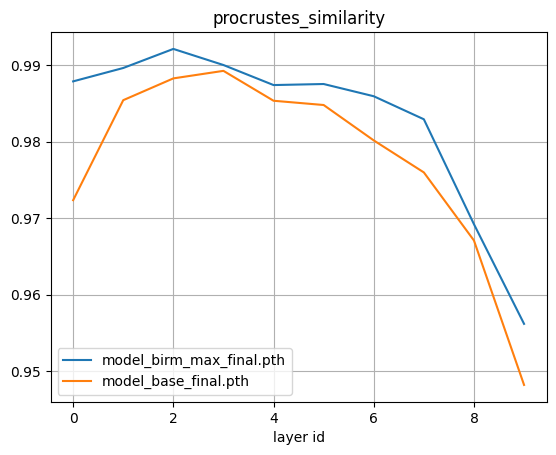

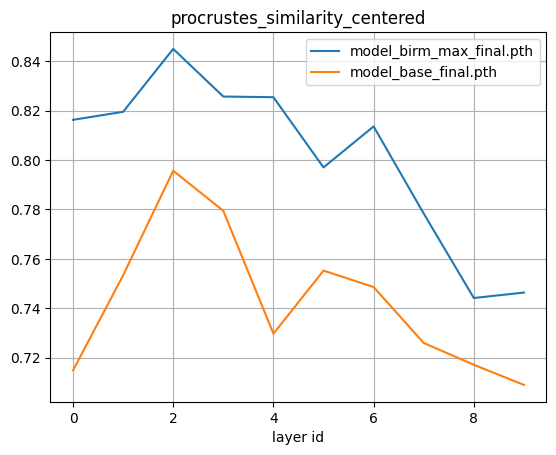

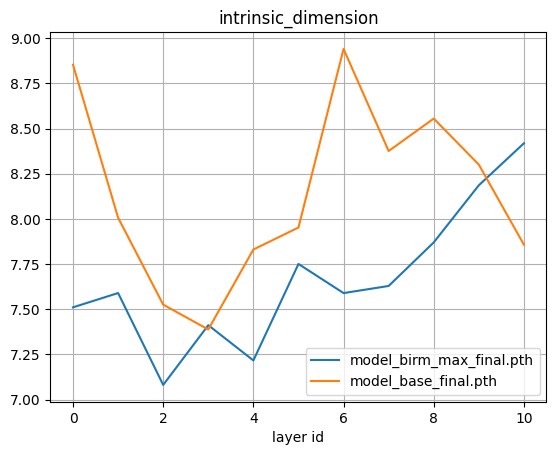

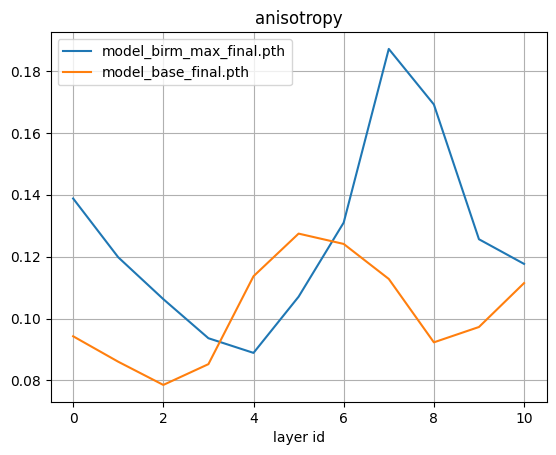

In [12]:
for metric_name in all_results.keys():
    plt.title(metric_name)
    plt.grid()
    plt.xlabel("layer id")
    for model_name in all_results[metric_name].keys():
        plt.plot(all_results[metric_name][model_name][1:], label=model_name)
    plt.legend()
    plt.show()